In [1]:
from my_functions import*

In [2]:
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") #opening the Root file with Uproot 

In [3]:
MuonTree_ZeroBias=file["MuonTree_ZeroBias;1"]
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

#Select range of events
nmin=0
nmax=10000

#Select quality 0 Z->mumu
Zmumu_pt=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin:nmax]
Zmumu_eta=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin:nmax]
Zmumu_phi=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin:nmax]
#And select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi = get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)
#Select the ZeroBias data with energy cut
ZeroBias_eta=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())[nmin:nmax]
ZeroBias_phi=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())[nmin:nmax]
ZeroBias_pt=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())[nmin:nmax]

quality_selector: Only 21.265 % of the data has been selected
quality_selector: Only 21.265 % of the data has been selected
quality_selector: Only 21.265 % of the data has been selected


100%|██████████| 10000/10000 [00:06<00:00, 1465.00it/s]


energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut


In [4]:
#Computo isolations
dr_min=0.09
dr_max=0.3
res1=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max, [nmin, nmax], int((nmax-nmin)/10))
res2=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, [nmin, nmax], int((nmax-nmin)/10))

In [5]:
"""
#substract a global value of 5GeV to the isolation energies, and set negative results to 0
value=5*10**3

aux=ak.Array(res1)-value
res1_shift=ak.where(aux < 0, 0, aux)

aux=ak.Array(res2)-value
res2_shift=ak.where(aux < 0, 0, aux)

#Remove NaN
res1_shift=res1_shift[~np.isnan(res1_shift)]
res2_shift=res2_shift[~np.isnan(res2_shift)]
"""

'\n#substract a global value of 5GeV to the isolation energies, and set negative results to 0\nvalue=5*10**3\n\naux=ak.Array(res1)-value\nres1_shift=ak.where(aux < 0, 0, aux)\n\naux=ak.Array(res2)-value\nres2_shift=ak.where(aux < 0, 0, aux)\n\n#Remove NaN\nres1_shift=res1_shift[~np.isnan(res1_shift)]\nres2_shift=res2_shift[~np.isnan(res2_shift)]\n'

In [6]:
res1=ak.Array(res1)
res1=res1[~np.isnan(res1)]
res2=ak.Array(res2)
res2=res2[~np.isnan(res2)]

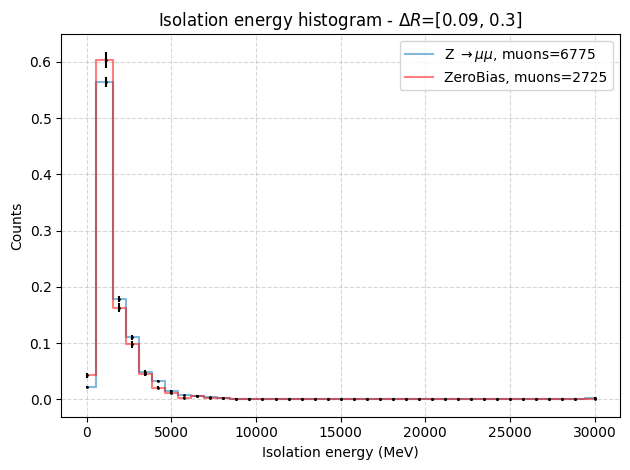

In [7]:
#Plot result
data1= ak.flatten(res1)
data2= ak.flatten(res2)
coolplot([data1, data2], np.linspace(0.0,3*10**4,40),
          labels=[fr"Z $\rightarrow \mu \mu$, muons={len(data1)}", fr"ZeroBias, muons={len(data2)}"], x_label="Isolation energy (MeV)",
          y_label="Counts", title=rf"Isolation energy histogram - $\Delta R$=[{dr_min}, {dr_max}]")

In [8]:
#Compute ratio
ratio1=ak.flatten(res1)/ak.flatten(Zmumu_pt[~np.isnan(res1)])
ratio2=ak.flatten(res2)/ak.flatten(ZeroBias_pt[~np.isnan(res2)])

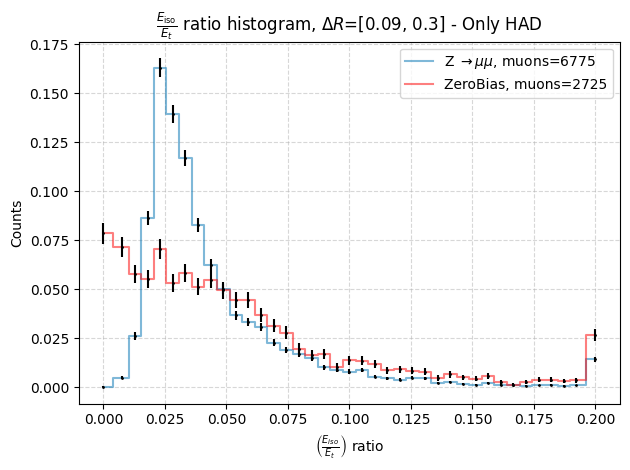

In [9]:
#Plot result
data1= ratio1
data2= ratio2
coolplot([ratio1, ratio2], np.linspace(0.0,0.2,40),labels=[fr"Z $\rightarrow \mu \mu$, muons={len(ratio1)}",
 fr"ZeroBias, muons={len(ratio2)}"], x_label=r"$\left(\frac{E_{iso}}{E_{t}}\right)$ ratio", y_label="Counts", 
 title = r"$\frac{{E_{{\text{{iso}}}}}}{{E_t}}$ ratio histogram, $\Delta R$=[{}, {}] - Only HAD".format(dr_min, dr_max))